User-Article Matrix Shape: (100, 4630)
Cosine Similarities Matrix Shape: (100, 100)
Euclidean Distances Matrix Shape: (100, 100)
Manhattan Distances Matrix Shape: (100, 100)
Cosine Similarities Matrix Sample:
[[1.   0.   0.   0.   0.02]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.02 0.   0.   0.   1.  ]]
Euclidean Distances Matrix Sample:
[[ 0.         10.         10.         10.          9.89949494]
 [10.          0.         10.         10.         10.        ]
 [10.         10.          0.         10.         10.        ]
 [10.         10.         10.          0.         10.        ]
 [ 9.89949494 10.         10.         10.          0.        ]]
Manhattan Distances Matrix Sample:
[[  0. 100. 100. 100.  98.]
 [100.   0. 100. 100. 100.]
 [100. 100.   0. 100. 100.]
 [100. 100. 100.   0. 100.]
 [ 98. 100. 100. 100.   0.]]


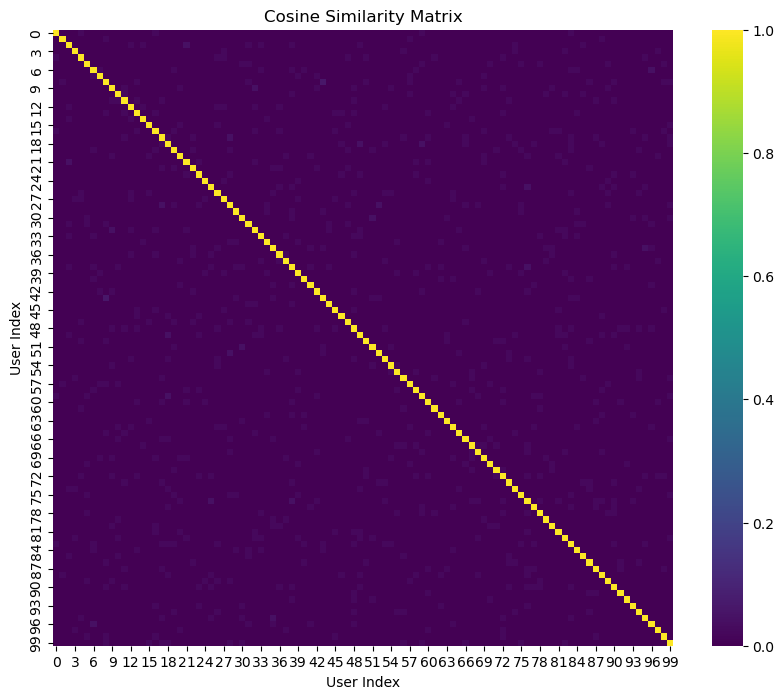

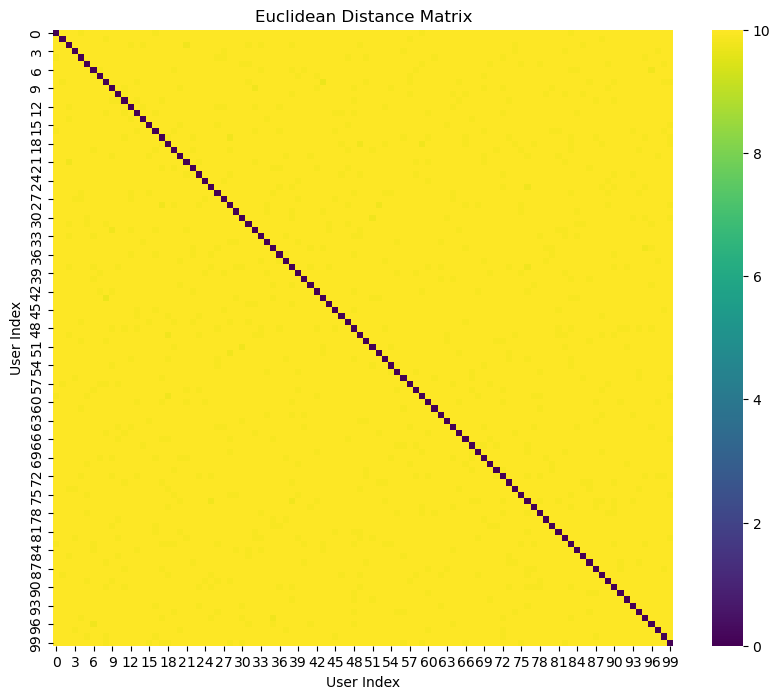

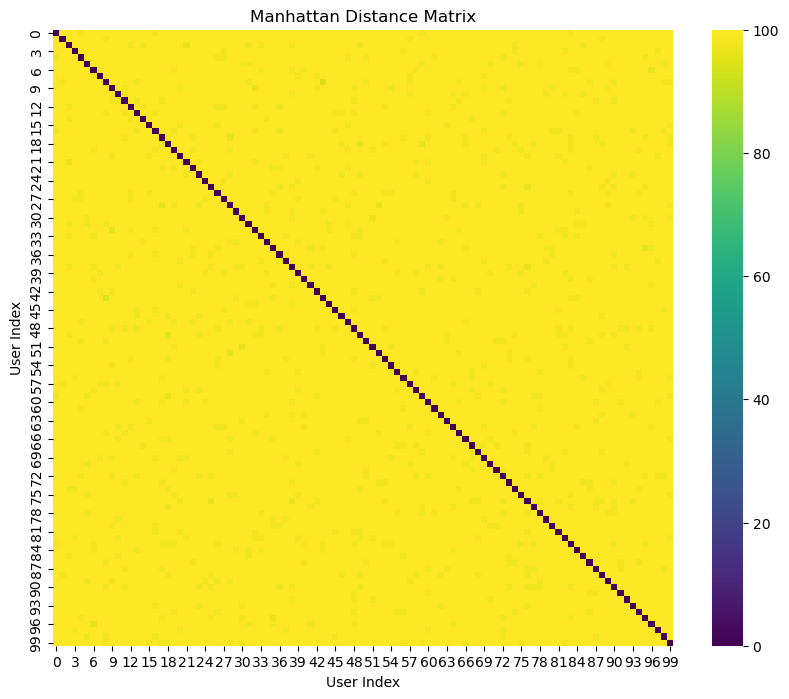

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import matplotlib.pyplot as plt
import seaborn as sns

interactions = pd.read_csv('user_interactions_bias_55_45.csv')

# User-article matrix
user_article_matrix = interactions.pivot_table(index='userId', columns='headlineId', values='interaction', fill_value=0)

print(f"User-Article Matrix Shape: {user_article_matrix.shape}")

# Calculate metrics 
cosine_similarities = cosine_similarity(user_article_matrix)
euclidean_dist = euclidean_distances(user_article_matrix)
manhattan_dist = manhattan_distances(user_article_matrix)

print("Cosine Similarities Matrix Shape:", cosine_similarities.shape)
print("Euclidean Distances Matrix Shape:", euclidean_dist.shape)
print("Manhattan Distances Matrix Shape:", manhattan_dist.shape)

print("Cosine Similarities Matrix Sample:")
print(cosine_similarities[:5, :5])
print("Euclidean Distances Matrix Sample:")
print(euclidean_dist[:5, :5])
print("Manhattan Distances Matrix Sample:")
print(manhattan_dist[:5, :5])

# Visualize matrix
def plot_similarity_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='viridis')
    plt.title(title)
    plt.xlabel('User Index')
    plt.ylabel('User Index')
    plt.show()

plot_similarity_matrix(cosine_similarities, 'Cosine Similarity Matrix')
plot_similarity_matrix(euclidean_dist, 'Euclidean Distance Matrix')
plot_similarity_matrix(manhattan_dist, 'Manhattan Distance Matrix')



In [2]:
clickbait_count = interactions['clickbait'].value_counts()
print("Distribution des interactions:")
print(clickbait_count)

Distribution des interactions:
clickbait
yes    2700
no     2300
Name: count, dtype: int64


In [3]:
def calculate_global_proportions(recommendations):
    clickbait_count = 0
    non_clickbait_count = 0
    total_count = 0

    for user_recommendations in recommendations:
        for article_id in user_recommendations:
            clickbait_status = interactions.loc[interactions['headlineId'] == article_id, 'clickbait'].values[0]
            if clickbait_status == 'yes':
                clickbait_count += 1
            else:
                non_clickbait_count += 1
            total_count += 1

    clickbait_proportion = (clickbait_count / total_count) * 100
    non_clickbait_proportion = (non_clickbait_count / total_count) * 100

    return clickbait_proportion, non_clickbait_proportion


In [7]:
def get_recommendations(similarity_matrix, user_id, k=5, top_n=5):
    user_idx = user_id - 1  # assuming userId starts from 1
    similarity_scores = list(enumerate(similarity_matrix[user_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    recommended_user_indices = [i for i, score in similarity_scores[1:k+1]]  # skipping self similarity
    
    recommended_articles = []
    for idx in recommended_user_indices:
        user_articles = user_article_matrix.iloc[idx]
        article_indices = user_articles[user_articles > 0].index
        
        # Ajouter tous les articles 
        recommended_articles.extend(article_indices)
    
    # Filtrer les articles uniques et limiter aux top_n recommandations
    recommended_articles = list(set(recommended_articles))[:top_n]
    return recommended_articles


In [8]:
all_recommendations = {'Cosine': [], 'Euclidean': [], 'Manhattan': []}
k = 3  # Try with 3, 5, 10 

for user_id in range(1, 101):
    recommended_articles_cosine = get_recommendations(cosine_similarities, user_id, k=k)
    recommended_articles_euclidean = get_recommendations(euclidean_dist, user_id, k=k)
    recommended_articles_manhattan = get_recommendations(manhattan_dist, user_id, k=k)

    all_recommendations['Cosine'].append(recommended_articles_cosine)
    all_recommendations['Euclidean'].append(recommended_articles_euclidean)
    all_recommendations['Manhattan'].append(recommended_articles_manhattan)

    print(f"\nUser {user_id} recommended articles (Cosine): {recommended_articles_cosine}")
    print(f"User {user_id} recommended articles (Euclidean): {recommended_articles_euclidean}")
    print(f"User {user_id} recommended articles (Manhattan): {recommended_articles_manhattan}")
    
# Vérifier la diversité et les proportions des recommandations pondérées
cosine_proportions = calculate_global_proportions(all_recommendations['Cosine'])
euclidean_proportions = calculate_global_proportions(all_recommendations['Euclidean'])
manhattan_proportions = calculate_global_proportions(all_recommendations['Manhattan'])

print(f"\nProportion of clickbait recommended (Cosine): {cosine_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Cosine): {cosine_proportions[1]:.2f}%")
print(f"Proportion of clickbait recommended (Euclidean): {euclidean_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Euclidean): {euclidean_proportions[1]:.2f}%")
print(f"Proportion of clickbait recommended (Manhattan): {manhattan_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Manhattan): {manhattan_proportions[1]:.2f}%")


User 1 recommended articles (Cosine): [23552, 13824, 26113, 8708, 28677]
User 1 recommended articles (Euclidean): [5, 5638, 12809, 17417, 4106]
User 1 recommended articles (Manhattan): [5, 5638, 12809, 17417, 4106]

User 2 recommended articles (Cosine): [14340, 4110, 4119, 4125, 6175]
User 2 recommended articles (Euclidean): [23552, 5638, 12809, 17417, 4106]
User 2 recommended articles (Manhattan): [23552, 5638, 12809, 17417, 4106]

User 3 recommended articles (Cosine): [21510, 22546, 21011, 4115, 12824]
User 3 recommended articles (Euclidean): [23552, 5638, 4106, 15884, 3085]
User 3 recommended articles (Manhattan): [23552, 5638, 4106, 15884, 3085]

User 4 recommended articles (Cosine): [16896, 19968, 25089, 16387, 31235]
User 4 recommended articles (Euclidean): [23552, 12809, 17417, 3085, 16910]
User 4 recommended articles (Manhattan): [23552, 12809, 17417, 3085, 16910]

User 5 recommended articles (Cosine): [16896, 16387, 6, 16402, 21528]
User 5 recommended articles (Euclidean): [5

In [9]:
all_recommendations = {'Cosine': [], 'Euclidean': [], 'Manhattan': []}
k = 5  # Try with 3, 5, 10 

for user_id in range(1, 101):
    recommended_articles_cosine = get_recommendations(cosine_similarities, user_id, k=k)
    recommended_articles_euclidean = get_recommendations(euclidean_dist, user_id, k=k)
    recommended_articles_manhattan = get_recommendations(manhattan_dist, user_id, k=k)

    all_recommendations['Cosine'].append(recommended_articles_cosine)
    all_recommendations['Euclidean'].append(recommended_articles_euclidean)
    all_recommendations['Manhattan'].append(recommended_articles_manhattan)

    print(f"\nUser {user_id} recommended articles (Cosine): {recommended_articles_cosine}")
    print(f"User {user_id} recommended articles (Euclidean): {recommended_articles_euclidean}")
    print(f"User {user_id} recommended articles (Manhattan): {recommended_articles_manhattan}")
    
# Vérifier la diversité et les proportions des recommandations pondérées
cosine_proportions = calculate_global_proportions(all_recommendations['Cosine'])
euclidean_proportions = calculate_global_proportions(all_recommendations['Euclidean'])
manhattan_proportions = calculate_global_proportions(all_recommendations['Manhattan'])

print(f"\nProportion of clickbait recommended (Cosine): {cosine_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Cosine): {cosine_proportions[1]:.2f}%")
print(f"Proportion of clickbait recommended (Euclidean): {euclidean_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Euclidean): {euclidean_proportions[1]:.2f}%")
print(f"Proportion of clickbait recommended (Manhattan): {manhattan_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Manhattan): {manhattan_proportions[1]:.2f}%")


User 1 recommended articles (Cosine): [23552, 13824, 26113, 8708, 28677]
User 1 recommended articles (Euclidean): [5, 5638, 2567, 27143, 12809]
User 1 recommended articles (Manhattan): [5, 5638, 2567, 27143, 12809]

User 2 recommended articles (Cosine): [14340, 12809, 17417, 4110, 5136]
User 2 recommended articles (Euclidean): [23552, 5, 5638, 2567, 27143]
User 2 recommended articles (Manhattan): [23552, 5, 5638, 2567, 27143]

User 3 recommended articles (Cosine): [20994, 21509, 21510, 8715, 19473]
User 3 recommended articles (Euclidean): [23552, 5, 5638, 2567, 27143]
User 3 recommended articles (Manhattan): [23552, 5, 5638, 2567, 27143]

User 4 recommended articles (Cosine): [16896, 19968, 25089, 16387, 31235]
User 4 recommended articles (Euclidean): [23552, 5, 2567, 27143, 12809]
User 4 recommended articles (Manhattan): [23552, 5, 2567, 27143, 12809]

User 5 recommended articles (Cosine): [16896, 10753, 16387, 13829, 6]
User 5 recommended articles (Euclidean): [5, 5638, 2567, 27143,

In [10]:
all_recommendations_no_weighting = {'Cosine': [], 'Euclidean': [], 'Manhattan': []}
k = 10  # Try with 3, 5, 10 

for user_id in range(1, 101):
    recommended_articles_cosine = get_recommendations(cosine_similarities, user_id, k=k)
    recommended_articles_euclidean = get_recommendations(euclidean_dist, user_id, k=k)
    recommended_articles_manhattan = get_recommendations(manhattan_dist, user_id, k=k)

    all_recommendations['Cosine'].append(recommended_articles_cosine)
    all_recommendations['Euclidean'].append(recommended_articles_euclidean)
    all_recommendations['Manhattan'].append(recommended_articles_manhattan)

    print(f"\nUser {user_id} recommended articles (Cosine): {recommended_articles_cosine}")
    print(f"User {user_id} recommended articles (Euclidean): {recommended_articles_euclidean}")
    print(f"User {user_id} recommended articles (Manhattan): {recommended_articles_manhattan}")
    
# Vérifier la diversité et les proportions des recommandations pondérées
cosine_proportions = calculate_global_proportions(all_recommendations['Cosine'])
euclidean_proportions = calculate_global_proportions(all_recommendations['Euclidean'])
manhattan_proportions = calculate_global_proportions(all_recommendations['Manhattan'])

print(f"\nProportion of clickbait recommended (Cosine): {cosine_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Cosine): {cosine_proportions[1]:.2f}%")
print(f"Proportion of clickbait recommended (Euclidean): {euclidean_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Euclidean): {euclidean_proportions[1]:.2f}%")
print(f"Proportion of clickbait recommended (Manhattan): {manhattan_proportions[0]:.2f}%")
print(f"Proportion of non-clickbait recommended (Manhattan): {manhattan_proportions[1]:.2f}%")


User 1 recommended articles (Cosine): [28677, 5, 22536, 4106, 28684]
User 1 recommended articles (Euclidean): [16385, 5, 8200, 4106, 14347]
User 1 recommended articles (Manhattan): [16385, 5, 8200, 4106, 14347]

User 2 recommended articles (Cosine): [14340, 5, 4106, 4110, 20497]
User 2 recommended articles (Euclidean): [16385, 5, 8200, 4106, 14347]
User 2 recommended articles (Manhattan): [16385, 5, 8200, 4106, 14347]

User 3 recommended articles (Cosine): [14338, 14347, 8204, 22546, 4115]
User 3 recommended articles (Euclidean): [16385, 5, 8200, 4106, 14347]
User 3 recommended articles (Manhattan): [16385, 5, 8200, 4106, 14347]

User 4 recommended articles (Cosine): [16387, 5, 8204, 20497, 24595]
User 4 recommended articles (Euclidean): [16385, 5, 8200, 14347, 4110]
User 4 recommended articles (Manhattan): [16385, 5, 8200, 14347, 4110]

User 5 recommended articles (Cosine): [16387, 6, 26635, 14349, 16402]
User 5 recommended articles (Euclidean): [16385, 5, 8200, 4106, 14347]
User 5 r